In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [799]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [800]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [801]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [802]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout 

In [887]:
data = np.load('data/feature_extract_reshaped.npy')
data.shape

(13330, 30, 63)

In [888]:
import numpy as np

# Assuming data is your original 3D array

# Assuming the first column contains the IDs
ids_column = data[:, 0, 0]

# Find unique epoch IDs
unique_epoch_ids = np.unique(ids_column)

# Shuffle the unique epoch IDs
np.random.shuffle(unique_epoch_ids)

# Calculate the number of unique epoch IDs for training, validation, and testing
train_samples_nr = int(np.floor(0.8 * len(unique_epoch_ids)))
validation_samples_nr = int(np.floor(0.2 * train_samples_nr))
test_samples_nr = len(unique_epoch_ids) - train_samples_nr

# Split the unique epoch IDs into train, validation, and test sets
train_sample_ids = unique_epoch_ids[:train_samples_nr]
validation_sample_ids = train_sample_ids[:validation_samples_nr]
test_sample_ids = unique_epoch_ids[train_samples_nr:]

# Create boolean masks for filtering
train_mask = np.in1d(ids_column, train_sample_ids)
validation_mask = np.in1d(ids_column, validation_sample_ids)
test_mask = np.in1d(ids_column, test_sample_ids)

# Apply the masks to create train, validation, and test samples
train_sample = data[train_mask, :, :]
validation_sample = data[validation_mask, :, :]
test_sample = data[test_mask, :, :]

print(f'train shape',train_sample.shape)
print(f'validation shape',validation_sample.shape)
print(f'test shape',test_sample.shape)

train shape (10664, 30, 63)
validation shape (2108, 30, 63)
test shape (2666, 30, 63)


In [889]:
X_train = train_sample[:,:,2:-1]
X_test = test_sample[:,:,2:-1]
X_val = validation_sample[:,:,2:-1]

Y_train = train_sample[:,:,-1]
Y_test = test_sample[:,:,-1]
Y_val = validation_sample[:,:,-1]


In [717]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size = 0.2)

In [873]:
X_train.shape

(10664, 30, 60)

In [874]:
Y_test.shape

(2666, 30)

In [890]:
y_test=Y_test.max(axis=1)
y_train=Y_train.max(axis=1)
y_val= Y_val.max(axis=1)
y_test.shape

(2666,)

In [876]:
shape=X_train.shape[1:]
shape

(30, 60)

In [891]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

#model.add(normalizer)

# Recurrent layer
model.add(LSTM(72, return_sequences=False))

# Fully connected layer
model.add(Dense(72, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
learning_rate = 0.001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # Create callbacks
# callbacks = EarlyStopping(monitor='val_loss', patience=5)

In [878]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_test, return_counts=True)
total_samples = len(y_test)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [879]:
class_weight_dict

{0.0: 0.5657894736842105, 1.0: 4.3}

In [886]:
y_train.shape

(2666,)

In [892]:
## look at validation batch ?
history = model.fit(X_train,  y_train, 
                    batch_size=100, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=300,
                    validation_data=(X_val, y_val))
                    #validation_split = 0.2)

Epoch 1/300
107/107 [==============================] - 11s 40ms/step - loss: 0.8864 - accuracy: 0.4806 - val_loss: 0.6575 - val_accuracy: 0.6006
Epoch 2/300
 16/107 [===>..........................] - ETA: 2s - loss: 0.7940 - accuracy: 0.4944

In [728]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

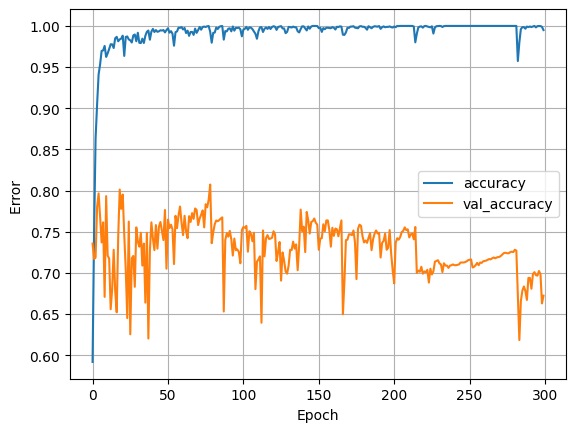

In [816]:
plot_accuracy(history)

In [443]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

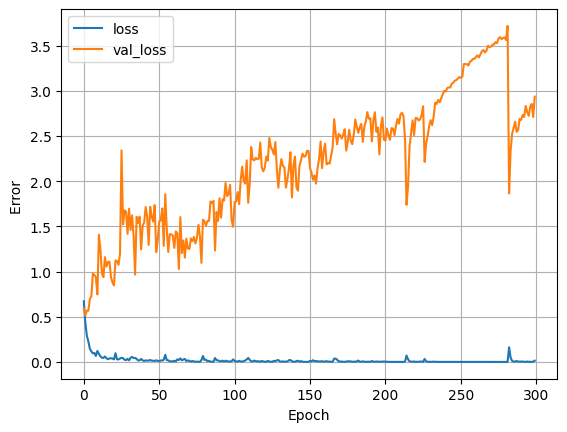

In [817]:
plot_loss(history)

In [818]:
model.evaluate(
    X_test,
    y_test, verbose=0)

[2.1313302516937256, 0.7554388642311096]

In [819]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

84/84 - 0s - loss: 2.1313 - accuracy: 0.7554 - 435ms/epoch - 5ms/step
Model accuracy: 0.7554388642311096


In [750]:
y_pred_train = model.predict(X_train)
y_pred_train

334/334 [==============================] - 3s 5ms/step


array([[9.9999815e-01],
       [1.3922184e-07],
       [3.3647816e-06],
       ...,
       [4.7654751e-08],
       [1.1154250e-08],
       [3.2711274e-04]], dtype=float32)

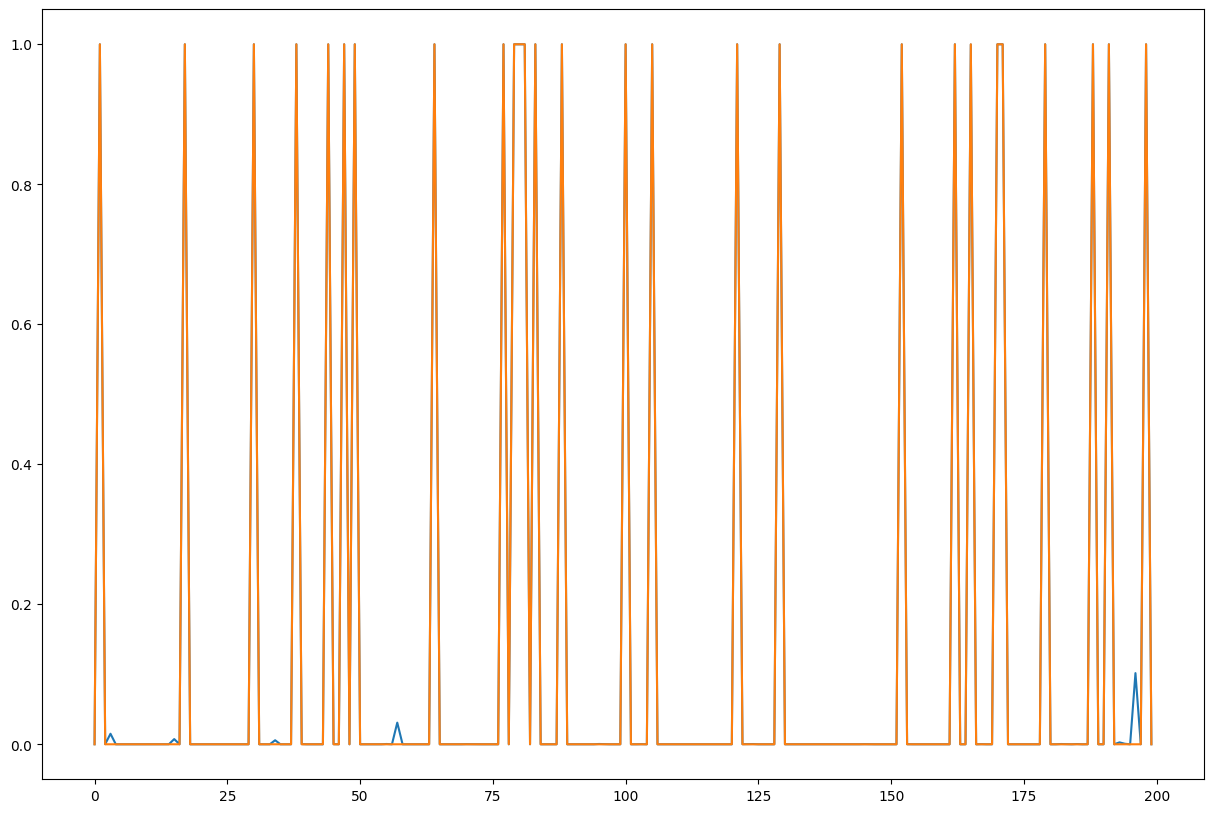

In [676]:
plt.figure(figsize=(15,10))  # Adjust the width and height as needed
plt.plot(y_pred_train[:200])
plt.plot(y_train[:200])


In [820]:
y_pred = model.predict(X_test)
y_pred

84/84 [==============================] - 2s 6ms/step


array([[5.7045177e-06],
       [4.2800943e-06],
       [4.0115087e-06],
       ...,
       [2.5800444e-04],
       [1.5854066e-05],
       [1.5117840e-05]], dtype=float32)

In [821]:
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

(2666, 1)

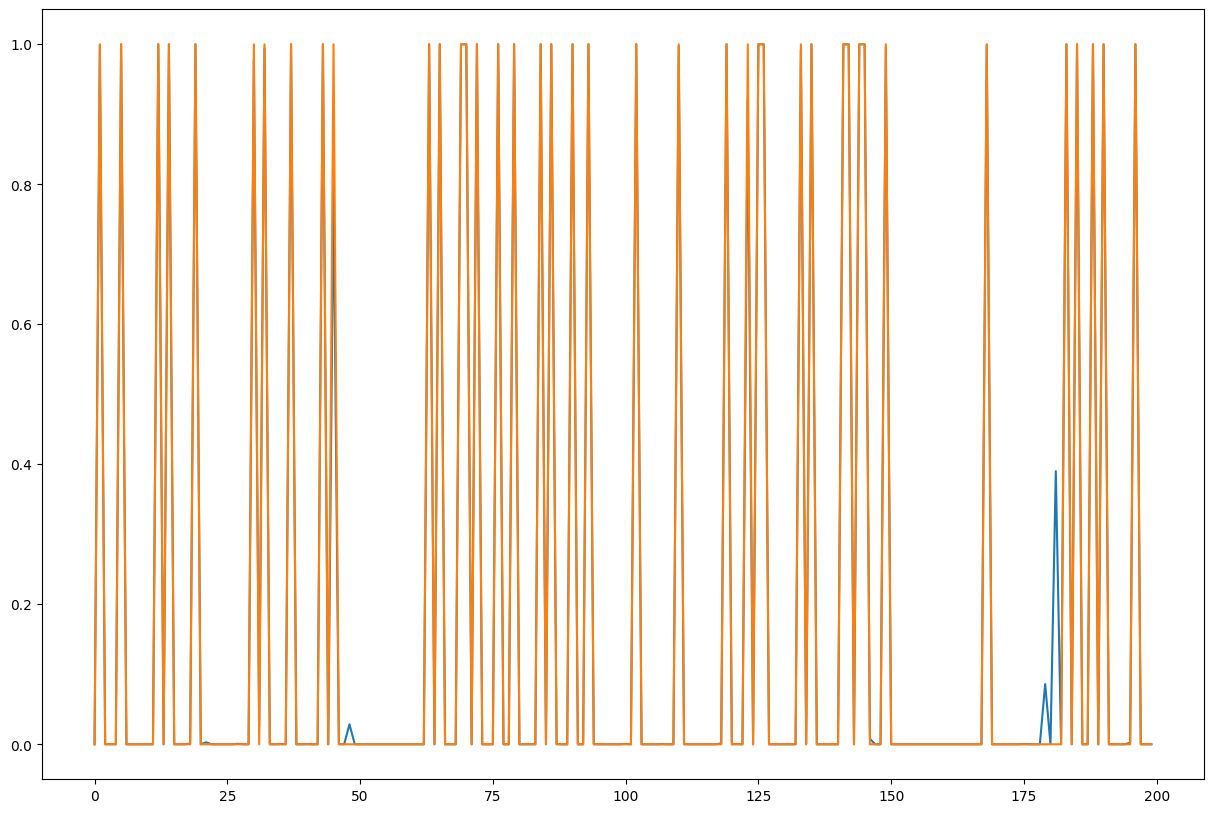

In [677]:
plt.figure(figsize=(15,10))  
plt.plot(y_pred[:200])
plt.plot(y_test[:200])

In [822]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

84/84 [==============================] - 0s 6ms/step - loss: 2.1313 - accuracy: 0.7554
Loss: 2.1313302516937256
Accuracy: 0.7554388642311096
Precision: 0.09669811320754718
Recall: 0.13225806451612904


(310.0, 424)

In [634]:
sum(y_test==0)

2294

In [635]:
y_test.shape

(2666,)

In [636]:
sum(y_pred_c==1)

array([397])

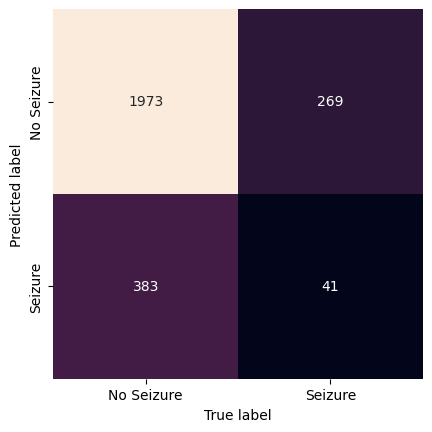

In [823]:
from sklearn.metrics import confusion_matrix, classification_report
mat = confusion_matrix(y_test, y_pred_c)
labels = ['No Seizure', 'Seizure']
# Create the heatmap with custom labels
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

In [673]:
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2294
         1.0       0.99      0.99      0.99       372

    accuracy                           1.00      2666
   macro avg       0.99      1.00      0.99      2666
weighted avg       1.00      1.00      1.00      2666



Text(0, 0.5, 'Predictions')

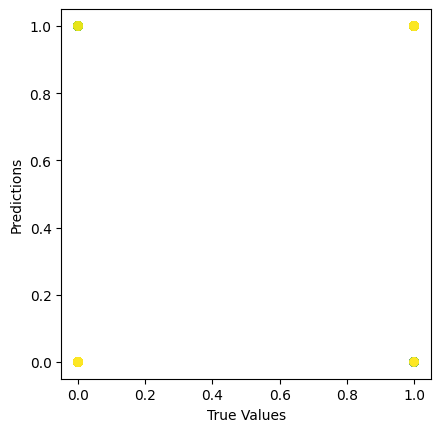

In [633]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_c,c=np.arange(len(y_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

In [678]:
# error = y_pred_c - y_test
# plt.hist(error, bins=25)
# plt.xlabel('Prediction Error')
# _ = plt.ylabel('Count')

In [13]:
# def make_model(input_shape):
#     input_layer = keras.layers.Input(input_shape)

#     conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
#     conv1 = keras.layers.BatchNormalization()(conv1)
#     conv1 = keras.layers.ReLU()(conv1)

#     conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
#     conv2 = keras.layers.BatchNormalization()(conv2)
#     conv2 = keras.layers.ReLU()(conv2)

#     conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.ReLU()(conv3)

#     gap = keras.layers.GlobalAveragePooling1D()(conv3)

#     output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

#     return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [17]:
# model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [268]:
# epochs = 500
# batch_size = 32

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["sparse_categorical_accuracy"],
# )
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     #validation_split=0.2,
#     verbose=1,


inputs: A 3D tensor with shape [batch, timesteps, feature].

In [694]:
# Define a sequential model
model = keras.Sequential()

#model.add(normalizer)

# Add an input layer with an input shape of (time_steps, input_features)
model.add(layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))

# Add a SimpleRNN layer with 32 units (neurons)
model.add(layers.SimpleRNN(32, activation='tanh'))

model.add(BatchNormalization())

# Add the output layer with 1 neuron and sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [689]:
X_train.shape

(10664, 30, 60)

In [688]:
y_train.shape

(10664,)

In [695]:
history = model.fit(X_train,  y_train, 
                    batch_size=100, epochs=200,
                    validation_split = 0.2)

Epoch 1/200
86/86 [==============================] - 4s 13ms/step - loss: 0.6345 - accuracy: 0.7092 - val_loss: 0.5099 - val_accuracy: 0.8340
Epoch 2/200
86/86 [==============================] - 1s 6ms/step - loss: 0.4627 - accuracy: 0.8405 - val_loss: 0.4310 - val_accuracy: 0.8514
Epoch 3/200
86/86 [==============================] - 1s 6ms/step - loss: 0.3939 - accuracy: 0.8607 - val_loss: 0.3952 - val_accuracy: 0.8519
Epoch 4/200
86/86 [==============================] - 1s 6ms/step - loss: 0.3667 - accuracy: 0.8634 - val_loss: 0.3885 - val_accuracy: 0.8523
Epoch 5/200
86/86 [==============================] - 1s 6ms/step - loss: 0.3541 - accuracy: 0.8638 - val_loss: 0.3697 - val_accuracy: 0.8537
Epoch 6/200
86/86 [==============================] - 1s 6ms/step - loss: 0.3393 - accuracy: 0.8686 - val_loss: 0.3590 - val_accuracy: 0.8584
Epoch 7/200
86/86 [==============================] - 1s 7ms/step - loss: 0.3258 - accuracy: 0.8729 - val_loss: 0.3508 - val_accuracy: 0.8626
Epoch 8/200


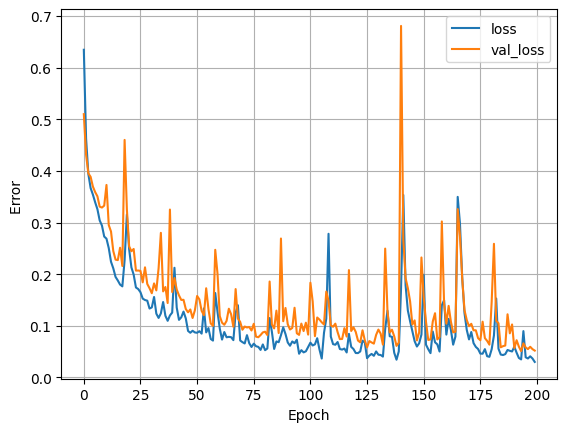

In [696]:
plot_loss(history)

In [697]:
y_pred = model.predict(X_test).flatten()
y_pred

84/84 [==============================] - 0s 3ms/step


array([4.2275383e-04, 9.9038714e-01, 6.7640208e-03, ..., 5.1450948e-05,
       1.6211814e-04, 9.9987376e-01], dtype=float32)

In [698]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

84/84 - 0s - loss: 0.0478 - accuracy: 0.9835 - 217ms/epoch - 3ms/step
Model accuracy: 0.9834958910942078


In [699]:
from sklearn.metrics import precision_score, recall_score
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

84/84 [==============================] - 0s 3ms/step - loss: 0.0478 - accuracy: 0.9835
Loss: 0.04779340326786041
Accuracy: 0.9834958910942078
Precision: 0.9456521739130435
Recall: 0.9354838709677419


(372.0, 368)

In [ ]:

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')